# Summary

## Project summary
A movie recommendation system developed for studies purpose. The dataset used in this notebook was kindly provided by the GroupLens Research (http://grouplens.org/datasets/) and describes 5-star rating and free-text tagging activity from MovieLens (http://movielens.org), a movie recommendation service. The original database contained over 25 million ratings and over 1 million tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019. As this the main objective is educational, several rows were removed from the analysis as explained during this notebook.

The dataset was merged with other datasets using the TMDB API (https://www.themoviedb.org/documentation/api). 

*Project developed by: Bernardo Caiado, Bruno Madureira, Joaquim O. Neto e Roger Rendom.*

## Databases

This study used 3 different datasets from the GroupLens Research based on information collected via the MovieLens website:

**GroupLens Research**:
- Links: contains movie keys from the GroupLens Research, Tmdb website and Imdb website.
- Movies: contains the movie title and genres information for each movie on the dataset.
- Ratings: contains the user Id, ratings for each evaluated movie and the timestamp.
- Tags: contains the user Id, movie Id, tags for each evaluated movie and the timestamp (these tags were not used as the tmdb dataset is that contains keyword is larger than the tags dataset)

**Tmdb API**: \
4 different datasets were generated using the Tmdb API (https://developers.themoviedb.org/). The purpuse of this interaction is to gather more information from the movies to be used in a selection model later on.
- Movies cast: dataset with a json that contains several information such as gender, actors, and others (only the actor list was used in this study.
- Movies crew: dataset with a json that contains several crew informations that was used to gather the movie director.
- Movies details: dataset that contains movie details such as language, movie overview, release date, vote average, number of votes, runtime and popularity.
- Movies keywords: dataset with keywords for each movie (which is larger than the tags available on the 'tags' dataset and therefore was used in this model.

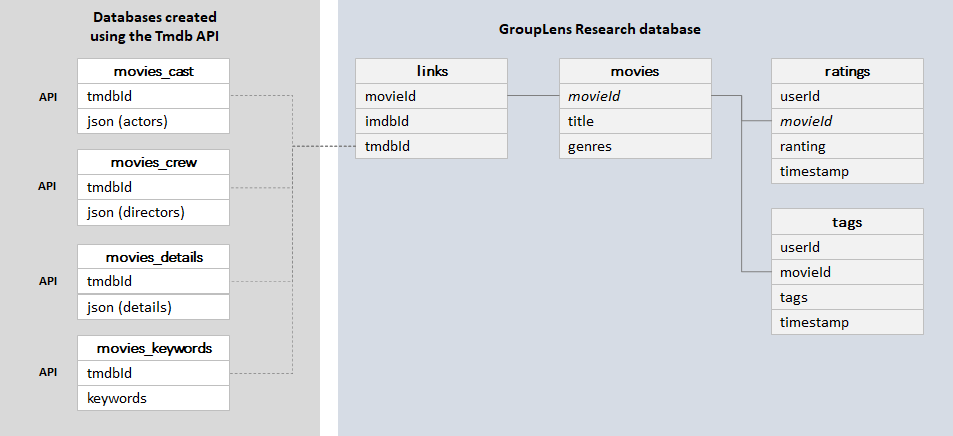

# Database setup

In [1]:
import pandas as pd
import numpy as np

## MovieLens database

Importing databases from the MovieLens dataset:

In [2]:
links = pd.read_csv('../raw_data/ml-25m/links.csv')
movies = pd.read_csv('../raw_data/ml-25m/movies.csv')
ratings = pd.read_csv('../raw_data/ml-25m/ratings.csv')
tags = pd.read_csv('../raw_data/ml-25m/tags.csv')
print(f'Movies database shape:',(movies.shape))
print(f'Ratings database shape:',(ratings.shape))
print(f'Links database shape:',(links.shape))
print(f'Tags database shape:',(tags.shape))

Movies database shape: (62423, 3)
Ratings database shape: (25000095, 4)
Links database shape: (62423, 3)
Tags database shape: (1093360, 4)


 ### Movies dataset

#### Exploratory analysis

In [3]:
movies.head(4)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance


**Note:** The genres columns contains the **genre** for each movie but the format is not the most appropriate for data analysis. Thus, this column **must be fixed** before progressing.

In [4]:
print(movies.isnull().sum())
movies.info()

movieId    0
title      0
genres     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


**```Main observations:```** dataset looks clean, without duplacate and/or blank spaces. However, the column genre must be converted to a list before using this information. A further evaluation showed that some movies had '(no genres listed)' listed and this should be treated as well.

#### Database cleansing (standardizing movie genres)

In [5]:
def clean_genres(x):
    """
    A fuction to standardize/separate the movie genre and substitute 'no genres listed' for a blank space.
    """
    
    if x == '(no genres listed)':
        return ""
    else:
        genre = x.replace("|"," ")
        return genre.split()

In [6]:
movies['genres'] = movies['genres'].apply(clean_genres)
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"


 ### Ratings dataset

#### Exploratory analysis

In [7]:
print(ratings.isnull().sum())
ratings.info()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [8]:
ratings.head(4)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820


**```Notes```**: This database looks fine and working.

### Links dataset

#### Exploratory analysis

This is one of the most important datasets as it has the TMDB ID which is the key to link the MovieLens dataset with the TMDB API and pull informations from it as explained above.

In [9]:
links.head(4)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0


An introdutory analysis showed that there are **107 movies without a tmdb Id**. These movies **will be removed** from the analysis as the tmdbId is the key to connect important features using the Tmdb API.

In [10]:
print(links.isnull().sum())
links.info()

movieId      0
imdbId       0
tmdbId     107
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


Some of the TMDB Ids were also duplicated as the original dataset had a problem.

In [11]:
duplicates = pd.DataFrame(links.tmdbId.value_counts())
nduplicates = duplicates[duplicates['tmdbId']>1].sum()
print(f'The number of movies with the TMDB ID duplicated is', nduplicates[0])

The number of movies with the TMDB ID duplicated is 69


**```Main observations:```** there are 107 movies without a TMDB Id and another 69 with duplicated TMDB Ids. This represents a total of 176 movies which is **less than 0.3%** of the movies in the original dataset.

#### Database cleansing (removing movies without a TMDB id and duplicates)

Before proceding is also possible to take a closer look at the list of missing movies by running the following command:

In [12]:
# Creating a missing movies dataframe:
missing_movies = links.copy()
missing_movies['empty'] = missing_movies.tmdbId.notnull()

# Checking the quantity of missing movies:
print(missing_movies['empty'].value_counts())
missing_movies = missing_movies[missing_movies['empty'] == False]
missing_movies = missing_movies.merge(movies,on='movieId').drop(columns=['empty','imdbId'])
missing_movies.head(5)

# Running the following command will generate a HTML file with the complete list:
# missing_movies.to_html('list_of_missing_movies.html')

True     62316
False      107
Name: empty, dtype: int64


,movieId,tmdbId,title,genres
0,721,NaN,Halfmoon (Paul Bowles - Halbmond) (1995),[Drama]
1,730,NaN,Low Life (1994),[Drama]
2,770,NaN,Costa Brava (1946),[Drama]
3,791,NaN,"Last Klezmer: Leopold Kozlowski, His Life and ...",[Documentary]
4,1107,NaN,Loser (1991),[Comedy]


**```Note:```** Our analysis showed that there almost no popular movies in the missing list.

In [13]:
# Dropping NANs e Duplicates (Tmdb ID)
links.dropna(inplace=True)
links.drop_duplicates(subset=['tmdbId'],inplace = True)

# Reseting the Links database index:
links.reset_index(inplace = True, drop=True)
len(links)

62281

### Double-checking the GroupLens database cleansing:

**Dataset lenghts:** \
There is a difference on the number of movies in the Movie Dataset since some movies where removed from the links dataset. It is importante to merge both datasets. 

In [14]:
print("The Movies dataset contains",len(movies),"movies, while the Links dataset contains",len(links),"movies. \
Therefore is important to do left merge of the Movies dataset on the Links dataset.")

The Movies dataset contains 62423 movies, while the Links dataset contains 62281 movies. Therefore is important to do left merge of the Movies dataset on the Links dataset.


The movie dataset will now be reduced and the data cleansing on the GroupLens dataset will be done for the moment.

In [15]:
movies = links.merge(movies,on='movieId').drop(columns=['imdbId'])
movies.head(4)

,movieId,tmdbId,title,genres
0,1,862.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,8844.0,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,15602.0,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,31357.0,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"


## The TMDB API

The TMDB API provides a broad range of information regarding movies, shows and TV episodes. With the TMDB ID available in GroupLens dataset several informations can be colleted. Due to the size of the request as well as the response **(json format)** this project generated 4 different dataset based on the API data:
* Movies details
* Movies keywords
* Movies crew
* Movies director

**```Notes:```** 
* To use the TMDB API is necessary to obtain a Key. For further explanation read the TMDB API documentation. The key should not be used for commercial purpose without TMDB's approval.
* The data collected from the API will also be treated since some of information requested were not available as explained below.



### Movies Details dataset:
This dataset was created from a json containing movie language, overview, TMDB popularity, release date, runtime, vote average and number of votes. These features were gathered to possibly be used in the recommendation model and or output.

#### Collecting Movie Details from the API:

In [16]:
import requests

def get_details(id_):
    """
    function to get movie details from the tmdb api
    url example: https://api.themoviedb.org/3/movie/215?api_key=f43b45256508300c9a0553da491121f5&language=en-US
    """
    key = 'f43b45256508300c9a0553da491121f5'
    language = 'en-US' 
    
    
    try:
        url =f'https://api.themoviedb.org/3/movie/{id_}?api_key={key}&language={language}'
        response = requests.get(url)
       
        if response.status_code != 200:
            return None

        data = response.json() 
        
        lang = data['original_language']
        overview = data['overview']
        pop = data['popularity']
        poster= data['poster_path']
        genres = data['genres']
        release = data['release_date']
        runtime = data['runtime']
        vote_avg = data['vote_average']
        vote_count = data['vote_count']
        
        
        return {'language':lang, 'overview':overview, 'genres': genres,
                'popularity':pop, 'poster_path':poster ,'release':release, 
                'runtime':runtime, 'vote_average':vote_avg,
                'vote_count': vote_count}
    
    
    except:
        return None


In [17]:
# Create a dataset movies_details based on the movies dataset from GroupLens (line commented)
# movies_details = movies.copy().drop(columns=['title','genres'])

# Apply get_movie_details function (this will take a while, therefore the command line will be commented)
# movies_details['details'] = movies_details['tmdbId'].apply(get_details)

# Save the database into a CSV file to prevent problems (command line commented)
# movies_details.to_csv('../raw_data/tmdb-api/movies_details.csv', index=False)
# movies_details.head(2)

#### Database cleansing (Movies Details)

In [18]:
# Importing the database from the saved file.
movies_details = pd.read_csv('../raw_data/tmdb-api/movies_details.csv')
print(f'The total number of movies withouth movies detail is', movies_details.details.isnull().sum())
movies_details.head(2)

The total number of movies withouth movies detail is 619


,movieId,tmdbId,details
0,1,862.0,"{'language': 'en', 'overview': ""Led by Woody, ..."
1,2,8844.0,"{'language': 'en', 'overview': ""When siblings ..."


The dataset is missing data from 619 movies which will be removed from the analysis.

In [19]:
movies_details.dropna(inplace=True)
print(f'The current movie_details lenght is:', len(movies_details))

The current movie_details lenght is: 61662


The data collected from the API/CSV file actually returned a string, not a dictionary as expected. In order to fix this field is possible to use the AST library (Abstract Syntax Trees) that converts an array string object to an array, but first we will remove 620 movies that didn't get a proper response from the TMDB API.

In [20]:
print(f'details stype:',type(movies_details.iloc[0]['details']))

details stype: <class 'str'>


In [21]:
import ast

def to_array(x):
    """
    Apply the literal eval on a string array object to convert it to an array object.
    """
    return ast.literal_eval(x)

In [22]:
# Substituting an array string object for an array
movies_details['details'] = movies_details['details'].apply(to_array)

A good practice will be to treat the information inside the dictionary and turn them into columns to facilitate data manipulation. **All the genres** will be transformed into a list removing any unnecessary information.

In [23]:
def standardize_genres(x):
    """
    Function to get genres from movies and turn them into a list to facilitate manipulation.
    """
    
    try:
        genres =[]
        count = 0

        while count < len(x['genres']):
            genres.append(x['genres'][count]['name'])
            count = count+1

        del(x['genres']) #delete former genre key and values
        x['genres']=genres #create a new genre key with a list containing all the movie's genre
        return x
    
    except:
        return "" #return empty if genre is missing


In [24]:
# Standardizing the movie genres string object for an array
movies_details['details'] = movies_details['details'].apply(standardize_genres)

In [25]:

movies_details[movies_details['tmdbId']==49026]
movies_details[movies_details['movieId']==91529]

,movieId,tmdbId,details
17408,91529,49026.0,"{'language': 'en', 'overview': 'Following the ..."


The columns that are going to be created the keys of the dictionary containing the movie details.

In [26]:
# Define columns to be created
columns = list(movies_details.iloc[0].details.keys())
print(f'dictionary keys:', columns)

# Create a dataframe with dictionary keys and values
details_in_columns = pd.DataFrame.from_records(movies_details.details.values, columns = columns)

# Check the shape of the new dataframe (details_in_columns)
print('')
print(f'The number of movies in the new dataframe is still', len(details_in_columns))
details_in_columns.reset_index(drop=True)

# Merge the new data sate with the original Movies_details database.
movies_details.reset_index(inplace = True, drop = True)
movies_details[columns] = details_in_columns
movies_details.drop(columns=['details'], inplace= True)
movies_details.reset_index(inplace = True,drop=True)

dictionary keys: ['language', 'overview', 'popularity', 'poster_path', 'release', 'runtime', 'vote_average', 'vote_count', 'genres']

The number of movies in the new dataframe is still 61662


In [27]:
movies_details[movies_details['tmdbId']==49026]

,movieId,tmdbId,language,overview,popularity,poster_path,release,runtime,vote_average,vote_count,genres
17346,91529,49026.0,en,Following the death of District Attorney Harve...,45.837,/vzvKcPQ4o7TjWeGIn0aGC9FeVNu.jpg,2012-07-16,165.0,7.7,16943,"[Action, Crime, Drama, Thriller]"


### Movies Keywords dataset:
This dataset was created to obtain keywords given by users to the movies in the TMDB website. Although the original GroupLeans dataset provided some tags, TMDB keywords were also taken to train the recommendation model.

#### Collecting Movie Keywords from the API:

In order to colect only the movies that is in the movies details database, we will generate a movies_keywords dataset based on a copy of the movies detail dataset and drop unnecessary columns.

In [28]:
movies_keywords = movies_details.drop(columns=['movieId','genres','language','overview','popularity','poster_path',
                                               'release', 'runtime','vote_average','vote_count'])

With a shorter list of movies is possible to create a function to get the keywords.

In [29]:
def get_keywords(id_):
    """
    function to get movie details from the tmdb api
    url example: https://api.themoviedb.org/3/movie/215/keywords?api_key=f43b45256508300c9a0553da491121f5&language=en-US
    """
    api_key = 'f43b45256508300c9a0553da491121f5'
    
    try:
        data = requests.get(f'https://api.themoviedb.org/3/movie/{id_}/keywords?api_key={api_key}')
        if data.status_code != 200:
            return "" 
            
        data = data.json()
        
        x=0
        keywords = []
    
        while x < len(data['keywords']):
            
            for i in data['keywords']:
                keywords.append(i['name'])
                x+=1
                     
        return keywords
    
    except:
        return ""

In [30]:
#Create a keywords column to get keywords from the API (this will take a while, therefore the command line will be commented):
# movies_keywords['keywords'] = movies_keywords['tmdbId'].apply(get_keywords)

# Save the database into a CSV file to prevent problems (command line commented)
# movies_keywords.to_csv('../raw_data/tmdb-api/movies_keywords2.csv', index=False)
# movies_keywords.head(2)

#### Database cleansing (Movies Keywords):

In [31]:
movies_keywords = pd.read_csv('../raw_data/tmdb-api/movies_keywords.csv')
movies_keywords.head(2)

,tmdbId,keywords
0,862.0,"['martial arts', 'jealousy', 'toy', 'friendshi..."
1,8844.0,"['giant insect', 'board game', 'jungle', 'disa..."


In [32]:
print(f'the number of null results are:',movies_keywords.keywords.isnull().sum(),'movies. \
      All of them will be removed from our analysis.')
movies_keywords.dropna(inplace=True)
movies_keywords.reset_index(inplace=True, drop = True)

the number of null results are: 7 movies.       All of them will be removed from our analysis.


Converting keywords type to array:

In [33]:
movies_keywords['keywords'] = movies_keywords['keywords'].apply(to_array)

As we can see there are 17700 movies without keywords but we will keep the database without further modifications for now.

In [34]:
##############
##############
### ADJUST ###
##############
##############
##############


### Movies Cast dataset:

This dataset provides the top 3 actors for each movie or less if it is the case.

#### Collecting Movie Cast from the API

In [35]:
def get_cast(id_):
    """
    This function will get the cast from the movie using the TMDB API.
    """
    api_key = 'f43b45256508300c9a0553da491121f5' 
    cast = []
    
    try:
        response = requests.get(f'https://api.themoviedb.org/3/movie/{id_}/credits?api_key={api_key}&language=en-US').json()
        i = len(response['cast'])
        for member in response['cast']:
            cast.append(member)
        return cast
    
    except:
        return cast
    
    return

In [36]:
# Create a datafram based on the movies existing in the keywords dataset
# movies_cast = movies_keywords.drop(columns='keywords').copy()

# Create a column 'cast' and run 
# movies_cast['cast'] = movies_cast['tmdbId'].apply(get_cast)

# Save the database into a CSV file to prevent problems (command line commented)
# movies_cast.to_csv('../raw_data/tmdb-api/movies_cast.csv', index=False)

#### Database cleansing (Movie Cast)

In [37]:
movies_cast = pd.read_csv('../raw_data/tmdb-api/movies_cast.csv')
movies_cast.head(2)

,tmdbId,cast
0,862.0,"[{'adult': False, 'gender': 2, 'id': 31, 'know..."
1,8844.0,"[{'adult': False, 'gender': 2, 'id': 2157, 'kn..."


In [38]:
movies_cast['cast'] = movies_cast['cast'].apply(to_array)

In order to simplify our model we will use only the top 3 actors of a movie (or less if it is the case).

In [39]:
def get_top3_actors(x):
    """
    This function will get only the top 3 actors of a movie.
    """
    
    actor=[]
    try:
        actor.append(x[0]['name'])
    except:
        return actor
    try:
        actor.append(x[1]['name'])
    except:
        return actor
    try:
        actor.append((x[2]['name']))
        return actor
    except:
        return actor

In [40]:
movies_cast['actors'] =movies_cast['cast'].apply(get_top3_actors)
movies_cast.drop(columns=['cast'],inplace = True)
movies_cast.reset_index(drop=True,inplace=True)

In [41]:
movies_cast.head(2)

,tmdbId,actors
0,862.0,"[Tom Hanks, Tim Allen, Don Rickles]"
1,8844.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]"


### Movies Crew dataset:
This dataset provides the director of the movie.

#### Collecting Movie Crew from the API:

In [42]:
def get_crew(id_):
    
    """
    Get moview crew information from the API which includes the moviee director.
    """
    
    api_key = 'f43b45256508300c9a0553da491121f5' 
    cast = []
    
    try:
        data = requests.get(f'https://api.themoviedb.org/3/movie/{id_}/credits?api_key={api_key}&language=en-US').json()
        i = len(data['crew'])
        for member in data['crew']:
            cast.append(member)
        return cast
    except:
        return cast

In [43]:
# Create a datafram based on the movies existing in the keywords dataset
# movies_crew = movies_keywords.drop(columns='keywords').copy()

# Create a column 'cast' and run 
# movies_crew['crew'] = movies_cast['tmdbId'].apply(get_crew)

# Save the database into a CSV file to prevent problems (command line commented)
# movies_crew.to_csv('../raw_data/tmdb-api/movies_crew2.csv', index=False)

#### Database cleansing (Movie Crew)

In [44]:
movies_crew = pd.read_csv('../raw_data/tmdb-api/movies_crew.csv')
movies_crew.head(2)

,tmdbId,crew
0,862.0,"[{'adult': False, 'gender': 2, 'id': 7, 'known..."
1,8844.0,"[{'adult': False, 'gender': 2, 'id': 511, 'kno..."


In [45]:
movies_crew['crew'] = movies_crew['crew'].apply(to_array)

Now we will use only the director from the movie:

In [46]:
def get_director(x):
    director=[]
    for i in x:
        for key, value in i.items():
            if key == 'job':
                if value == 'Director':
                    director.append(i['name'])
    return director

In [47]:
# Use function to get only the director from the movie
movies_crew['director'] = movies_crew['crew'].apply(get_director)

# Drop column crew as this information won't be used and reset index to prevent problemns.
movies_crew.drop(columns=['crew'],inplace=True)
movies_crew.reset_index(drop=True, inplace = True)
print(len(movies_crew))
movies_crew.head(2)

61655


,tmdbId,director
0,862.0,[John Lasseter]
1,8844.0,[Joe Johnston]


### Merged API dataset
This dataset will be used to train the containt based similarity model.

#### Merging Details, Keywords, Cast and Crew datasets:

In [92]:
data =[]

In [93]:
data = movies_details.merge(movies_keywords, on='tmdbId')
data.head(1)

,movieId,tmdbId,language,overview,popularity,poster_path,release,runtime,vote_average,vote_count,genres,keywords
0,1,862.0,en,"Led by Woody, Andy's toys live happily in his ...",58.282,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,1995-10-30,81.0,7.9,13191,"[Animation, Adventure, Family, Comedy]","[martial arts, jealousy, toy, friendship, bull..."


In [94]:
data = data.merge(movies_cast, on='tmdbId')
data.head(1)

,movieId,tmdbId,language,overview,popularity,poster_path,release,runtime,vote_average,vote_count,genres,keywords,actors
0,1,862.0,en,"Led by Woody, Andy's toys live happily in his ...",58.282,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,1995-10-30,81.0,7.9,13191,"[Animation, Adventure, Family, Comedy]","[martial arts, jealousy, toy, friendship, bull...","[Tom Hanks, Tim Allen, Don Rickles]"


In [95]:
data = data.merge(movies_crew, on='tmdbId')
data.head(1)

,movieId,tmdbId,language,overview,popularity,poster_path,release,runtime,vote_average,vote_count,genres,keywords,actors,director
0,1,862.0,en,"Led by Woody, Andy's toys live happily in his ...",58.282,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,1995-10-30,81.0,7.9,13191,"[Animation, Adventure, Family, Comedy]","[martial arts, jealousy, toy, friendship, bull...","[Tom Hanks, Tim Allen, Don Rickles]",[John Lasseter]


In [96]:
titles = movies.copy()
titles = titles.rename(columns={'genres':'genres_movie_lens'})
titles.drop(columns=['movieId'],inplace=True)
titles.reset_index(drop = True, inplace = True)

In [97]:
data = data.merge(titles, on='tmdbId')

A further evaluation of the datasets showed us that the GroupLens genre information seems to be a little better than the information gathered via the API. Thus, we will remove the genre column from the API from the dataset that will be used to be trained later on.

In [98]:
data = data.drop(columns=['genres'])
data = data.rename(columns={'genres_movie_lens':'genres'})

#### Database cleansing (Data)

Since the original dataset is still very complete with over 60.000 movies, all the rows with null information will be dropped from the dataset

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61655 entries, 0 to 61654
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       61655 non-null  int64  
 1   tmdbId        61655 non-null  float64
 2   language      61655 non-null  object 
 3   overview      61655 non-null  object 
 4   popularity    61655 non-null  float64
 5   poster_path   56533 non-null  object 
 6   release       61655 non-null  object 
 7   runtime       61497 non-null  float64
 8   vote_average  61655 non-null  float64
 9   vote_count    61655 non-null  int64  
 10  keywords      61655 non-null  object 
 11  actors        61655 non-null  object 
 12  director      61655 non-null  object 
 13  title         61655 non-null  object 
 14  genres        61655 non-null  object 
dtypes: float64(4), int64(2), object(9)
memory usage: 7.5+ MB


In [100]:
data.dropna(inplace = True)
print(f'The new shape of the dataset is',len(data),'rows/movies.')

The new shape of the dataset is 56437 rows/movies.


However there are a few lines that contains empty lists and were not removed from the original dataset.

In [101]:
data = data[data.keywords.str.len()>0]
data = data[data.actors.str.len()>0]
data = data[data.director.str.len()>0]
data = data[data.genres.str.len()>0]

We will only keep movies from specific languages.

In [102]:
lang = ['en', 'fr', 'es', 'de', 'pt', 'it']
data['delete_language'] = data['language'].apply(lambda x: x in lang)
data = data[data['delete_language']==True]
data.reset_index(drop=True, inplace= True)

# Re-order columns to facilitate 
data = data[['movieId','tmdbId','title','genres','actors','director','overview','keywords','language','popularity','poster_path','release','runtime','vote_average','vote_count']]

# Drop Title Duplicates
data.drop_duplicates(subset=['title'],inplace = True)
print(f'The final shape of the dataset is',len(data),'rows/movies.')


The final shape of the dataset is 33010 rows/movies.


In [103]:
# Save dataframe to CSV file
#data.to_csv('../raw_data/treated-db/data.csv', index=False)

# Recommendation Models

We are goint to use 2 different recommendation models in this project: 

**- Content-Based Filtering:** this model will check similarities between movies and return a list containing the most similar movies to the selected one. \
**- Collaraborative Filtering:** this model will check similarities between users' preferences and recommend movies based on a list of movies and their scores provided by a person.

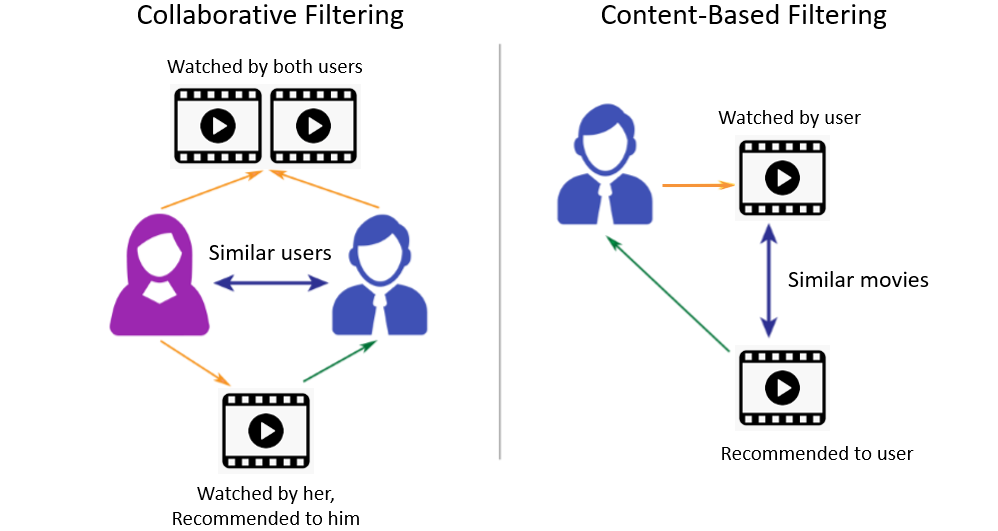
*Image source: <https://www.kdnuggets.com/2019/11/content-based-recommender-using-natural-language-processing-nlp.html>*

## Content-based model
This model will take into account the description of a movie which may include several features (e.g. title, director, actors, keywords, overview, etc.) and compare it features to other's movies features. The whole idea of this model is to use the Count-Vectorizer method from the Scikit Learn library to convert a collection of text documents into a matrix of token counts (the result will be a sparse matrix that contains the movies x vectorized words). From the count-vectorizer matrix it is possible to can create a cosine similarity matrix that will contain the cosine similarity between every movie. 

### Database setup

#### Database reduction

In order to have a faster model we are only going to use the top voted movies from the dataset. Thus, we will only consider movies that had at least 30 votes on the TMDB website. The new dataset will be called **'data_lite'**.

In [104]:
print(f'The dataset will be reduced from',len(data),'to',len(data[data['vote_count']>=100]),'movies.')

The dataset will be reduced from 33010 to 9565 movies.


In [105]:
# Importing CSV file
data_lite = pd.read_csv('../raw_data/treated-db/data.csv')

In [106]:
# Selecting only movies with over 100 votes.
data_lite = data[data['vote_count']>=100]
data_lite.reset_index(drop = True, inplace = True)
data_lite = data_lite.copy()

# Save dataframe to CSV file
# data_lite.to_csv('../raw_data/treated-db/data_lite.csv', index=False)

#### Turning lists into string and creating a soup column
This step is important as the count vectorizer model only recognizes strings not lists. \
Two different models will be trained:
- Content1: this model will have title, genres, overview, keywords, actors, directors and will overfit.
- Content2: this model will only consider keywords, actors, directors and genres.

In [107]:
# Feature engeenering functions

import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def to_lower_case(x):
    # Transform a list to a list of lower-case strings.
    actor = []
    for i in x:
        actor.append(i.lower())
    return actor

def remove_blank_spaces(x):
    # remove blank spaces from a strings in a list.
    actor = []
    for i in x:
        actor.append(i.replace(" ",""))
    return actor

def remove_punctuation(x):
    #remove punctiation from text
    for i in string.punctuation:
        x = x.replace(i, '')
    return x

def stop_words(x):
    #remove stopwords from text
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(x)
    z = [w for w in word_tokens if not w in stop_words]
    return z

def remove_year_from_title(x):
    # remove year from title to use it as a feature in the soup column
    title = []
    x = str(x)[:-7]
    title.append(x)
    return title

def to_string(x):
    #transform to string
    z = ' '.join(x)
    return z

In [108]:
# Apply fuctions to the columns (this is necessary to create a bag of words (soup) and vectorize)

data_lite['overview_soup'] = data_lite['overview'].apply(lambda x: str(x).lower())
data_lite['overview_soup'] = data_lite['overview_soup'].apply(remove_punctuation)
data_lite['overview_soup'] = data_lite['overview_soup'].apply(stop_words)
data_lite['overview_soup'] = data_lite['overview_soup'].apply(to_string)

data_lite['actors_soup'] = data_lite['actors'].apply(to_lower_case)
data_lite['actors_soup'] = data_lite['actors_soup'].apply(remove_blank_spaces)
data_lite['actors_soup'] = data_lite['actors_soup'].apply(lambda x: str(x))
data_lite['actors_soup'] = data_lite['actors_soup'].apply(remove_punctuation)

data_lite['directors_soup'] = data_lite['director'].apply(to_lower_case)
data_lite['directors_soup'] = data_lite['directors_soup'].apply(remove_blank_spaces)
data_lite['directors_soup'] = data_lite['directors_soup'].apply(lambda x: str(x))
data_lite['directors_soup'] = data_lite['directors_soup'].apply(remove_punctuation)

data_lite['title_soup'] = data_lite['title'].apply(remove_year_from_title)
data_lite['title_soup'] = data_lite['title_soup'].apply(lambda x: str(x).lower())
data_lite['title_soup'] = data_lite['title_soup'].apply(remove_punctuation)
data_lite['title_soup'] = data_lite['title_soup'].apply(stop_words)
data_lite['title_soup'] = data_lite['title_soup'].apply(to_string)

data_lite['genres_soup'] = data_lite['genres'].apply(to_lower_case)
data_lite['genres_soup'] = data_lite['genres_soup'].apply(remove_blank_spaces)
data_lite['genres_soup'] = data_lite['genres_soup'].apply(lambda x: str(x))
data_lite['genres_soup'] = data_lite['genres_soup'].apply(remove_punctuation)

data_lite['keywords_soup'] = data_lite['keywords'].apply(to_lower_case)
data_lite['keywords_soup'] = data_lite['keywords_soup'].apply(remove_blank_spaces)
data_lite['keywords_soup'] = data_lite['keywords_soup'].apply(lambda x: str(x))
data_lite['keywords_soup'] = data_lite['keywords_soup'].apply(remove_punctuation)


# CREATE SOUP AND CONVERT TO UNIQUE STRING

# Content1: this model will have title, genres, overview, keywords, actors, directors and will overfit.
# Content2: this model will only consider keywords, actors, directors and genres.
# Content3 (bonus): this model will have all the features from content 1 but the overview
data_lite['soup1'] = data_lite['title_soup'] + ' ' + data_lite['genres_soup'] + ' ' + data_lite['overview_soup'] + ' ' + data_lite['actors_soup'] + ' ' + data_lite['keywords_soup'] + ' ' + data_lite['directors_soup']
data_lite['soup2'] = data_lite['genres_soup'] + ' ' + data_lite['actors_soup'] + ' ' + data_lite['keywords_soup'] +' ' + data_lite['directors_soup']
data_lite['soup3'] = data_lite['title_soup'] + ' ' + data_lite['genres_soup'] +' ' + data_lite['actors_soup'] +' ' + data_lite['keywords_soup'] + ' ' +data_lite['directors_soup']

In [109]:
# Checking the soup from the movie 1 (Toy Story)
data_lite.iloc[0].soup1

'toy story adventure animation children comedy fantasy led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences tomhanks timallen donrickles martialarts jealousy toy friendship bullying elementaryschool friends rivalry rescue mission walkietalkie boynextdoor newtoy neighborhood toycomestolife resourcefulness johnlasseter'

In [110]:
data_lite.head(1)

,movieId,tmdbId,title,genres,actors,director,overview,keywords,language,popularity,...,vote_count,overview_soup,actors_soup,directors_soup,title_soup,genres_soup,keywords_soup,soup1,soup2,soup3
0,1,862.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[Tom Hanks, Tim Allen, Don Rickles]",[John Lasseter],"Led by Woody, Andy's toys live happily in his ...","[martial arts, jealousy, toy, friendship, bull...",en,58.282,...,13191,led woody andys toys live happily room andys b...,tomhanks timallen donrickles,johnlasseter,toy story,adventure animation children comedy fantasy,martialarts jealousy toy friendship bullying e...,toy story adventure animation children comedy ...,adventure animation children comedy fantasy to...,toy story adventure animation children comedy ...


In [111]:
# Export data to be trained not in a notebook:
# soup = data_lite.copy()
# soup.drop(columns=['overview_soup','actors_soup','directors_soup','title_soup','keywords_soup','genres_soup','soup1','soup3'],inplace=True)
# soup.to_csv('../raw_data/sim-model/soup.csv', index=False)

#### Creating a Count Vectorizer Matrix

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
# Import CountVectorizer and create the countvectorizer matrix

count1 = CountVectorizer()
count_matrix1 = count1.fit_transform(data_lite['soup1'])

count2 = CountVectorizer()
count_matrix2 = count2.fit_transform(data_lite['soup2'])

count3 = CountVectorizer()
count_matrix3 = count3.fit_transform(data_lite['soup3'])

In [113]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute the Cosine Similarity matrix based on the count_matrix
# The result of this step will be a matrix movie x movie containing the cosine similarity in the values

cosine_sim1 = cosine_similarity(count_matrix1, count_matrix1)
cosine_sim2 = cosine_similarity(count_matrix2, count_matrix2)
cosine_sim3 = cosine_similarity(count_matrix3, count_matrix3)

In [114]:
# Create a new dataframe from the original one.
# This dataframe will be used to return movies information based on a list containing the movies ordered by their similarity.

df = data_lite.copy()
df.drop(columns=['overview_soup','actors_soup','directors_soup','title_soup','genres_soup','keywords_soup','soup1','soup2','soup3'], inplace = True)

In [115]:
# Reset index from dataframe
df = df.reset_index()

# Define indices variable - a pandas series that will contain titles as their indices 
indices = pd.Series(df.index, index=df['title'])

In [116]:
def get_recommendations(title, cosine_sim):
    
    """
    This function will return a list of movies and their selected features ordered by their cosine similarity vs
    the selected movie.
    
    """
    
    # idx Get the index of the movie that matches the title
    idx = indices[title]

    # Sim_scores creates a list of all movies and the cosine similarity related to the movie selected in 'title'
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    # Note: Key is the field that the sort fuction will use to do the sort (position 1 of the tuple)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the X most similar movies (position 0 will be the selected movie)
    sim_scores = sim_scores[1:30]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Get the movie cosine scores:
    cosine_scores = [i[1] for i in sim_scores]
    
    # Return the top 10 most similar movies
    #return df2['title'].iloc[movie_indices]
    a=pd.DataFrame(df[['genres','title','actors','director','vote_average','popularity','poster_path']].iloc[movie_indices]).reset_index(drop=True)
    b=pd.DataFrame(cosine_scores, columns=['cosine_score'])
    
    return pd.concat([a,b], axis = 1).set_index('title')

In [117]:
print('=========')
print('Content 1')
print('Note: There is cleary a overfitting in this model. This was because title and overview features.')
print('=========')
get_recommendations('Dark Knight Rises, The (2012)', cosine_sim1)

Content 1
Note: There is cleary a overfitting in this model. This was because title and overview features.


,genres,actors,director,vote_average,popularity,poster_path,cosine_score
title,,,,,,,
"Dark Knight, The (2008)","[Action, Crime, Drama, IMAX]","[Christian Bale, Heath Ledger, Michael Caine]",[Christopher Nolan],8.5,51.538,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,0.356969
Batman Begins (2005),"[Action, Crime, IMAX]","[Christian Bale, Liam Neeson, Michael Caine]",[Christopher Nolan],7.7,44.064,/1P3ZyEq02wcTMd3iE4ebtLvncvH.jpg,0.310471
Batman: Gotham by Gaslight (2018),"[Action, Animation, Sci-Fi, Thriller]","[Bruce Greenwood, Jennifer Carpenter, Anthony ...",[Sam Liu],6.6,25.465,/7souLi5zqQCnpZVghaXv0Wowi0y.jpg,0.246183
Batman vs. Two-Face (2017),[Animation],"[Adam West, Burt Ward, William Shatner]",[Rick Morales],6.2,16.285,/yTbj8Kcp4WFwMRdEejnn55KIsfH.jpg,0.239046
Batman Forever (1995),"[Action, Adventure, Comedy, Crime]","[Val Kilmer, Tommy Lee Jones, Jim Carrey]",[Joel Schumacher],5.4,18.585,/k6EQ2OewzjF8TcPgok9wxpPAgXW.jpg,0.224490
DC Showcase: Catwoman (2011),"[Action, Adventure, Animation, Sci-Fi]","[Eliza Dushku, John DiMaggio, Liliana Mumy]",[Lauren Montgomery],6.9,8.909,/fwXRXd1PrmVr7YBc4Rl9ovAK1ID.jpg,0.220863
Death Wish (1974),"[Action, Crime, Drama]","[Charles Bronson, Hope Lange, Vincent Gardenia]",[Michael Winner],7.0,10.384,/n0MJPBLSCtt7DBYZGFsOfQkZCWt.jpg,0.213029
Batman (1989),"[Action, Crime, Thriller]","[Jack Nicholson, Michael Keaton, Kim Basinger]",[Tim Burton],7.2,27.080,/tDexQyu6FWltcd0VhEDK7uib42f.jpg,0.211380
Batman & Robin (1997),"[Action, Adventure, Fantasy, Thriller]","[George Clooney, Arnold Schwarzenegger, Chris ...",[Joel Schumacher],4.3,21.945,/bsg0mrxUKyJoL4oSGP5mlhEsqp.jpg,0.205263


In [118]:
print('=========')
print('Content 2')
print('Note: It seems like this model could be better generelized.')
print('=========')
get_recommendations('Dark Knight Rises, The (2012)', cosine_sim2)

Content 2
Note: It seems like this model could be better generelized.


,genres,actors,director,vote_average,popularity,poster_path,cosine_score
title,,,,,,,
"Dark Knight, The (2008)","[Action, Crime, Drama, IMAX]","[Christian Bale, Heath Ledger, Michael Caine]",[Christopher Nolan],8.5,51.538,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,0.511101
Batman Begins (2005),"[Action, Crime, IMAX]","[Christian Bale, Liam Neeson, Michael Caine]",[Christopher Nolan],7.7,44.064,/1P3ZyEq02wcTMd3iE4ebtLvncvH.jpg,0.473286
Kick-Ass 2 (2013),"[Action, Comedy, Crime]","[Aaron Taylor-Johnson, Chloë Grace Moretz, Chr...",[Jeff Wadlow],6.4,23.047,/4LUzG0blTn6JMhUwXSmjPqNFNXL.jpg,0.281284
Superman Returns (2006),"[Action, Adventure, Sci-Fi, IMAX]","[Brandon Routh, Kevin Spacey, Kate Bosworth]",[Bryan Singer],5.6,19.378,/ijSsWy2RWxTJzw3UMwFbXkjr5ny.jpg,0.278887
Man of Steel (2013),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]","[Henry Cavill, Amy Adams, Michael Shannon]",[Zack Snyder],6.5,36.327,/7rIPjn5TUK04O25ZkMyHrGNPgLx.jpg,0.278887
Batman v Superman: Dawn of Justice (2016),"[Action, Adventure, Fantasy, Sci-Fi]","[Ben Affleck, Henry Cavill, Jesse Eisenberg]",[Zack Snyder],5.9,50.116,/5UsK3grJvtQrtzEgqNlDljJW96w.jpg,0.261861
Iron Man 2 (2010),"[Action, Adventure, Sci-Fi, Thriller, IMAX]","[Robert Downey Jr., Gwyneth Paltrow, Don Cheadle]",[Jon Favreau],6.8,50.473,/6WBeq4fCfn7AN0o21W9qNcRF2l9.jpg,0.253546
Thor: The Dark World (2013),"[Action, Adventure, Fantasy, IMAX]","[Chris Hemsworth, Natalie Portman, Tom Hiddles...",[Alan Taylor],6.6,47.429,/wp6OxE4poJ4G7c0U2ZIXasTSMR7.jpg,0.253546
Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]","[Harrison Ford, Mark Hamill, Carrie Fisher]",[J.J. Abrams],7.4,66.437,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,0.253546


It's even possible to sort by features such as popularity, vote_average or even a new/created variable.

In [119]:
# Results sorted by the Most Popular Movies
get_recommendations('Dark Knight Rises, The (2012)', cosine_sim2).sort_values(by='popularity', ascending=False)

,genres,actors,director,vote_average,popularity,poster_path,cosine_score
title,,,,,,,
Justice League (2017),"[Action, Adventure, Sci-Fi]","[Ben Affleck, Henry Cavill, Amy Adams]",[Zack Snyder],6.2,109.302,/eifGNCSDuxJeS1loAXil5bIGgvC.jpg,0.218218
"Avengers, The (2012)","[Action, Adventure, Sci-Fi, IMAX]","[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],7.7,101.395,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,0.245976
Shazam! (2019),"[Action, Adventure, Fantasy, Sci-Fi]","[Zachary Levi, Asher Angel, Mark Strong]",[David F. Sandberg],7.0,96.383,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,0.221313
Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]","[Harrison Ford, Mark Hamill, Carrie Fisher]",[J.J. Abrams],7.4,66.437,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,0.253546
Teenage Mutant Ninja Turtles (2014),"[Action, Adventure, Comedy]","[Megan Fox, Will Arnett, William Fichtner]",[Jonathan Liebesman],5.9,65.415,/azL2ThbJMIkts3ZMt3j1YgBUeDB.jpg,0.221313
"Dark Knight, The (2008)","[Action, Crime, Drama, IMAX]","[Christian Bale, Heath Ledger, Michael Caine]",[Christopher Nolan],8.5,51.538,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,0.511101
Iron Man 2 (2010),"[Action, Adventure, Sci-Fi, Thriller, IMAX]","[Robert Downey Jr., Gwyneth Paltrow, Don Cheadle]",[Jon Favreau],6.8,50.473,/6WBeq4fCfn7AN0o21W9qNcRF2l9.jpg,0.253546
Batman v Superman: Dawn of Justice (2016),"[Action, Adventure, Fantasy, Sci-Fi]","[Ben Affleck, Henry Cavill, Jesse Eisenberg]",[Zack Snyder],5.9,50.116,/5UsK3grJvtQrtzEgqNlDljJW96w.jpg,0.261861
Iron Man 3 (2013),"[Action, Sci-Fi, Thriller, IMAX]","[Robert Downey Jr., Gwyneth Paltrow, Guy Pearce]",[Shane Black],6.9,49.377,/qhPtAc1TKbMPqNvcdXSOn9Bn7hZ.jpg,0.218218


In [120]:
# Results sorted by the Vote Average
get_recommendations('Dark Knight Rises, The (2012)', cosine_sim2).sort_values(by='vote_average', ascending=False)

,genres,actors,director,vote_average,popularity,poster_path,cosine_score
title,,,,,,,
"Dark Knight, The (2008)","[Action, Crime, Drama, IMAX]","[Christian Bale, Heath Ledger, Michael Caine]",[Christopher Nolan],8.5,51.538,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,0.511101
"Avengers, The (2012)","[Action, Adventure, Sci-Fi, IMAX]","[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],7.7,101.395,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,0.245976
Batman Begins (2005),"[Action, Crime, IMAX]","[Christian Bale, Liam Neeson, Michael Caine]",[Christopher Nolan],7.7,44.064,/1P3ZyEq02wcTMd3iE4ebtLvncvH.jpg,0.473286
Captain America: The Winter Soldier (2014),"[Action, Adventure, Sci-Fi, IMAX]","[Chris Evans, Scarlett Johansson, Sebastian Stan]","[Anthony Russo, Joe Russo]",7.7,27.250,/tVFRpFw3xTedgPGqxW0AOI8Qhh0.jpg,0.239046
Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]","[Harrison Ford, Mark Hamill, Carrie Fisher]",[J.J. Abrams],7.4,66.437,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,0.253546
Batman: Hush (2019),"[Action, Animation, Crime, Mystery]","[Jason O'Mara, Jennifer Morrison, Maury Sterling]",[Justin Copeland],7.4,38.123,/eiVQORVyVuNNZHPAELuWtlXoQsD.jpg,0.243975
Star Trek Into Darkness (2013),"[Action, Adventure, Sci-Fi, IMAX]","[Chris Pine, Zachary Quinto, Zoe Saldana]",[J.J. Abrams],7.3,22.688,/Aim3kVNh1MPIxPEFeJrl9e9Uf1a.jpg,0.232670
Batman (1989),"[Action, Crime, Thriller]","[Jack Nicholson, Michael Keaton, Kim Basinger]",[Tim Burton],7.2,27.080,/tDexQyu6FWltcd0VhEDK7uib42f.jpg,0.225877
Shazam! (2019),"[Action, Adventure, Fantasy, Sci-Fi]","[Zachary Levi, Asher Angel, Mark Strong]",[David F. Sandberg],7.0,96.383,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,0.221313


## Collaborative Filtering Model
In this model the user will be requested to evaluate some random movies and based on others user's preferences/similarities it will retrieve movies recommendations.

### Database setup and reduction

First is necessary to merge the users rating with the database_lite to assure we are only using the movies that are in the data_lite (the one that we used to create the content-based model). We will first only train our model using the top 1000 movies from the data_lite dataset in order to reduce computational costs.

In [340]:
data_lite_top = data_lite.copy()
data_lite_top = data_lite_top.sort_values(by='vote_count', ascending = False).reset_index(drop=True)
data_lite_top = data_lite[0:1000]
print(f'We will only use the top',len(data_lite_top),'voted movies on the TMDB website')

We will only use the top 1000 voted movies on the TMDB website


In [341]:
ratings_lite = ratings[['userId','movieId','rating']].merge(data_lite_top[['movieId','title']], on='movieId', how = 'inner')
ratings_lite.head()
print(f'The number of movies in the ratings lite database is:',ratings_lite.movieId.nunique())
print(f'The number reviews for theses movies is:',len(ratings_lite))

The number of movies in the ratings lite database is: 1000
The number reviews for theses movies is: 9086387


**```Note:```** The ratings_lite database is still very long. A exploratory analysis will help us drop some data that is not relevant for our analysis to make our process more generic and faster. The best way to optmize computacional costs is to have a dataframe with the most relevant movies.

In [342]:
data_users = ratings_lite.groupby(by='userId').count()

In [343]:
data_users.sort_values(by = 'title',inplace=True, ascending = False)
data_users.drop(columns=['title','movieId'],inplace = True)
data_users.rename(columns={'rating':'votes'},inplace=True)
print(f'The total number of users with votes in our ratings_lite dataset is:',len(data_users))
data_users.reset_index(inplace = True)
data_users.head(5)

The total number of users with votes in our ratings_lite dataset is: 161492


,userId,votes
0,122011,999
1,80974,931
2,57548,930
3,20055,908
4,92975,878


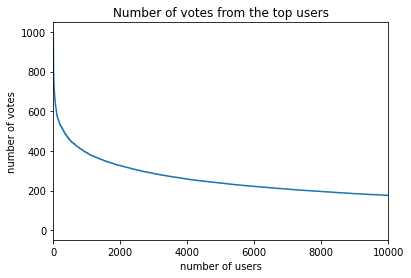

In [334]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(data_users.votes);
plt.xlim(0,10000);
plt.title('Number of votes from the top users');
plt.xlabel('number of users');
plt.ylabel('number of votes');

We now will reduce the number of users to optmize computacional costs. In order to do so, we will arbitrary use the top 10.000 users based on the number of votes on the MovieLens dataset. The chart above shows that the top users have rated at least 200 of these 1000 movies.

In [345]:
data_users = data_users[0:10000]
print(f'We will use only the top',len(data_users),'users in number of ratings (MovieLens ratings)')

We will use only the top 10000 users in number of ratings (MovieLens ratings)


In [346]:
print(f'The ratings_lite size before the users removel was',len(ratings_lite),'users.')
ratings_top = ratings_lite[['userId','movieId','rating','title']].merge(data_users[['userId']], on='userId', how = 'inner')
print(f'The ratings_lite size after the users removel is now',len(ratings_lite),'users.')

The ratings_lite size before the users removel was 9086387 users.
The ratings_lite size after the users removel is now 9086387 users.


In [347]:
# Save ratings_lite dataset into a CSV file:
#ratings_top.to_csv('../raw_data/sim-model/ratings_top.csv', index=True)

In [350]:
data_ratings = ratings_top.pivot(index='userId', columns='title', values='rating')
data_ratings

title,101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon On Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (8½) (1963),Above the Rim (1994),...,Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),Wyatt Earp (1994),"X-Files: Fight the Future, The (1998)",You Can't Take It with You (1938),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Zero Effect (1998)
userId,,,,,,,,,,,,,,,,,,,,,
12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
23,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,5.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,4.0,4.0,NaN,4.0,NaN,NaN,5.0
80,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN
120,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,5.0,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162507,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162516,3.5,4.5,3.0,4.0,2.5,4.5,NaN,2.0,2.0,NaN,...,3.5,4.0,3.5,2.0,3.5,1.5,4.0,2.5,2.0,4.0


In [435]:
import statistics

movies = {}
for i in data_ratings.columns:
    movies[i] = data_ratings[i].count()
print(f'The less rated movie has', min(movies.values()),'votes.')
print(f'The top rated movie has', max(movies.values()),'votes.')
print(f'The median of votes per movie is', int(statistics.median(movies.values())),'.')
votes = sorted(list(movies.values()))

The less rated movie has 49 votes.
The top rated movie has 9168 votes.
The median of votes per movie is 1986 .


In [436]:
movies = pd.DataFrame(movies.items(),columns=['movie','votes'])
movies.sort_values(by = 'votes',ascending = False, inplace = True)
movies.reset_index(drop=True,inplace=True)
movies.head(5)

,movie,votes
0,Forrest Gump (1994),9168
1,Jurassic Park (1993),9143
2,"Silence of the Lambs, The (1991)",9102
3,Star Wars: Episode IV - A New Hope (1977),9070
4,Pulp Fiction (1994),9047


In [437]:
import plotly.express as px
fig = px.line(movies, x="movie", y="votes", title='Total number of votes per movie')
fig.show()

### Model build-up